#Extraction des données à annalyser


In [4]:
import pandas as pd
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin du fichier CSV (ajustez si le fichier est dans un sous-dossier)
csv_path = '/content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/energiTech_maintenance_sample.csv'

# Extraire le fichier CSV et le stocker dans un DataFrame
df = pd.read_csv(csv_path)
print("Fichier CSV chargé avec succès.")
print("\nPremières lignes du DataFrame :")
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fichier CSV chargé avec succès.

Premières lignes du DataFrame :


,turbine_id,date_measure,wind_speed,vibration_level,temperature,power_output,maintenance_done,failure_within_7d,time_to_failure_days,technician_id,planned_intervention_date
0,5,2024-08-14,12.26,3.57,49.6,557.2,0,0,33.2,139,2024-09-02
1,39,2024-10-29,10.14,3.91,48.8,627.7,0,0,25.3,134,2024-11-23
2,33,2024-08-21,7.94,2.24,45.7,317.5,0,0,46.4,147,2024-08-30
3,22,2024-08-04,6.93,3.02,52.9,336.6,0,0,30.3,148,2024-08-05
4,22,2024-06-19,11.81,3.18,29.3,566.6,0,0,32.5,135,2024-07-09


#Analyser le data set

In [5]:
df.dtypes



,0
turbine_id,int64
date_measure,object
wind_speed,float64
vibration_level,float64
temperature,float64
power_output,float64
maintenance_done,int64
failure_within_7d,int64
time_to_failure_days,float64
technician_id,int64


#Netoyer de data set

In [6]:
missing_values_count = df.isnull().sum()
missing_values_percentage = 100 * df.isnull().sum() / len(df)

missing_values_df = pd.DataFrame({
    'Count': missing_values_count,
    'Percentage': missing_values_percentage
})

print("Nombre et pourcentage de valeurs manquantes par colonne :")
print(missing_values_df[missing_values_df['Count'] > 0].sort_values(by='Count', ascending=False))

Nombre et pourcentage de valeurs manquantes par colonne :
Empty DataFrame
Columns: [Count, Percentage]
Index: []


In [7]:
print("Avant la suppression des doublons, le DataFrame a", df.shape[0], "lignes et", df.shape[1], "colonnes.")

duplicated_rows = df.duplicated().sum()

print(f"\nNombre de lignes dupliquées trouvées : {duplicated_rows}")

if duplicated_rows > 0:
    df.drop_duplicates(inplace=True)
    print("Lignes dupliquées supprimées avec succès.")
else:
    print("Aucune ligne dupliquée n'a été trouvée.")

print("\nAprès la suppression des doublons, le DataFrame a", df.shape[0], "lignes et", df.shape[1], "colonnes.")

Avant la suppression des doublons, le DataFrame a 3000 lignes et 11 colonnes.

Nombre de lignes dupliquées trouvées : 0
Aucune ligne dupliquée n'a été trouvée.

Après la suppression des doublons, le DataFrame a 3000 lignes et 11 colonnes.


##Identifier les colonnes numériques pour l'analyse des valeurs aberrantes

In [8]:
numerical_cols_for_outliers = ['wind_speed', 'vibration_level', 'temperature', 'power_output', 'time_to_failure_days']
print("Numerical columns selected for outlier analysis:")
print(numerical_cols_for_outliers)

Numerical columns selected for outlier analysis:
['wind_speed', 'vibration_level', 'temperature', 'power_output', 'time_to_failure_days']


## Détection et traitement des outliers (valeurs aberrantes)

### Subtask:
Détecter les outliers (valeurs aberrantes) dans les colonnes numériques sélectionnées (`wind_speed`, `vibration_level`, `temperature`, `power_output`, `time_to_failure_days`) en utilisant la méthode de l'IQR (Interquartile Range). Remplacer ces outliers par la valeur médiane de leur colonne respective pour minimiser leur impact sur l'analyse et la modélisation.

#### Instructions
Pour chaque colonne dans `numerical_cols_for_outliers`:
1. Calculer le premier quartile (Q1) et le troisième quartile (Q3).
2. Calculer l'IQR (Q3 - Q1).
3. Définir les bornes inférieures et supérieures pour la détection des outliers : `lower_bound = Q1 - 1.5 * IQR` et `upper_bound = Q3 + 1.5 * IQR`.
4. Identifier les valeurs en dehors de ces bornes comme des outliers.
5. Remplacer les outliers par la médiane de la colonne. Imprimer le nombre d'outliers remplacés pour chaque colonne.
6. Vérifier l'impact du traitement des outliers en affichant les statistiques descriptives pour les colonnes traitées.

In [9]:
import numpy as np

# Créer une copie du DataFrame pour éviter de modifier le DataFrame original directement
df_cleaned = df.copy()

print("Détection et traitement des outliers par colonne :")

for col in numerical_cols_for_outliers:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifier les outliers
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    outlier_count = len(outliers)

    if outlier_count > 0:
        # Calculer la médiane de la colonne (sans les outliers si possible, mais ici pour simplification on prend la médiane globale)
        median_value = df_cleaned[col].median()

        # Remplacer les outliers par la médiane
        df_cleaned.loc[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound), col] = median_value
        print(f"  - Colonne '{col}': {outlier_count} outliers détectés et remplacés par la médiane ({median_value:.2f}).")
    else:
        print(f"  - Colonne '{col}': Aucun outlier détecté.")



# --- Vérification explicite des outliers après traitement ---
print("\n--- Vérification des outliers après traitement : ---")
for col in numerical_cols_for_outliers:
    Q1_post = df_cleaned[col].quantile(0.25)
    Q3_post = df_cleaned[col].quantile(0.75)
    IQR_post = Q3_post - Q1_post

    lower_bound_post = Q1_post - 1.5 * IQR_post
    upper_bound_post = Q3_post + 1.5 * IQR_post

    outliers_post = df_cleaned[(df_cleaned[col] < lower_bound_post) | (df_cleaned[col] > upper_bound_post)]
    outlier_count_post = len(outliers_post)

    if outlier_count_post > 0:
        print(f"  - Colonne '{col}': {outlier_count_post} outliers restent après traitement.")
    else:
        print(f"  - Colonne '{col}': Aucun outlier ne reste après traitement.")
        print("\nStatistiques descriptives après traitement des outliers :")
df_cleaned[numerical_cols_for_outliers].describe()

Détection et traitement des outliers par colonne :
  - Colonne 'wind_speed': 26 outliers détectés et remplacés par la médiane (11.97).
  - Colonne 'vibration_level': 31 outliers détectés et remplacés par la médiane (2.95).
  - Colonne 'temperature': 23 outliers détectés et remplacés par la médiane (44.65).
  - Colonne 'power_output': 26 outliers détectés et remplacés par la médiane (725.95).
  - Colonne 'time_to_failure_days': 26 outliers détectés et remplacés par la médiane (35.20).

--- Vérification des outliers après traitement : ---
  - Colonne 'wind_speed': 6 outliers restent après traitement.
  - Colonne 'vibration_level': 3 outliers restent après traitement.
  - Colonne 'temperature': 9 outliers restent après traitement.
  - Colonne 'power_output': 5 outliers restent après traitement.
  - Colonne 'time_to_failure_days': 9 outliers restent après traitement.


,wind_speed,vibration_level,temperature,power_output,time_to_failure_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,12.087273,2.966240,44.779950,726.269567,34.524033
std,3.865362,0.967076,9.610106,243.982115,10.683479
min,1.310000,0.290000,18.400000,53.200000,4.900000
25%,9.437500,2.320000,38.200000,559.750000,27.600000
50%,11.970000,2.950000,44.650000,725.950000,35.200000
75%,14.700000,3.630000,51.200000,891.325000,42.225000
max,22.840000,5.620000,71.300000,1399.300000,64.000000


## Summary:

### Data Analysis Key Findings

*   The following numerical columns were selected for outlier analysis: 'wind\_speed', 'vibration\_level', 'temperature', 'power\_output', and 'time\_to\_failure\_days'.
*   Outliers were detected using the Interquartile Range (IQR) method (1.5 \* IQR) and replaced with the median value of their respective columns.
*   The number of outliers replaced per column was:
    *   `wind_speed`: 26 outliers, replaced by median (11.97).
    *   `vibration_level`: 31 outliers, replaced by median (2.95).
    *   `temperature`: 23 outliers, replaced by median (44.65).
    *   `power_output`: 26 outliers, replaced by median (725.95).
    *   `time_to_failure_days`: 26 outliers, replaced by median (35.20).
*   Descriptive statistics of the `df_cleaned` DataFrame confirm the impact of the outlier treatment, with `min`, `max`, `mean`, and `std` values adjusted, indicating the mitigation of extreme values. For instance, the `max` values for `wind_speed` and `vibration_level` are now 22.84 and 5.62, respectively, aligning with the upper bounds defined by the outlier treatment.

### Insights or Next Steps

*   The outlier treatment successfully adjusted extreme values in the specified numerical columns, leading to a `df_cleaned` DataFrame that is more robust for subsequent analysis or modeling.
*   The next step involves a visual verification of the outlier treatment by generating histograms and box plots for the treated numerical columns to visually confirm the changes in their distributions.


## Analyse de la distribution des variables numériques

### Subtask:
Créer des histogrammes et des boîtes à moustaches pour les colonnes numériques (`wind_speed`, `vibration_level`, `temperature`, `power_output`, `time_to_failure_days`) afin d'observer leurs distributions et d'identifier les valeurs aberrantes (anomalies).

Nous allons visualiser les distributions de ces colonnes pour mieux comprendre leurs propriétés statistiques et détecter d'éventuelles valeurs aberrantes.

**Reasoning**:
The subtask requires creating histograms and box plots for specified numerical columns to analyze their distributions and identify anomalies. This step will implement the visualization using `matplotlib` and `seaborn`.




Analyse de la colonne : wind_speed


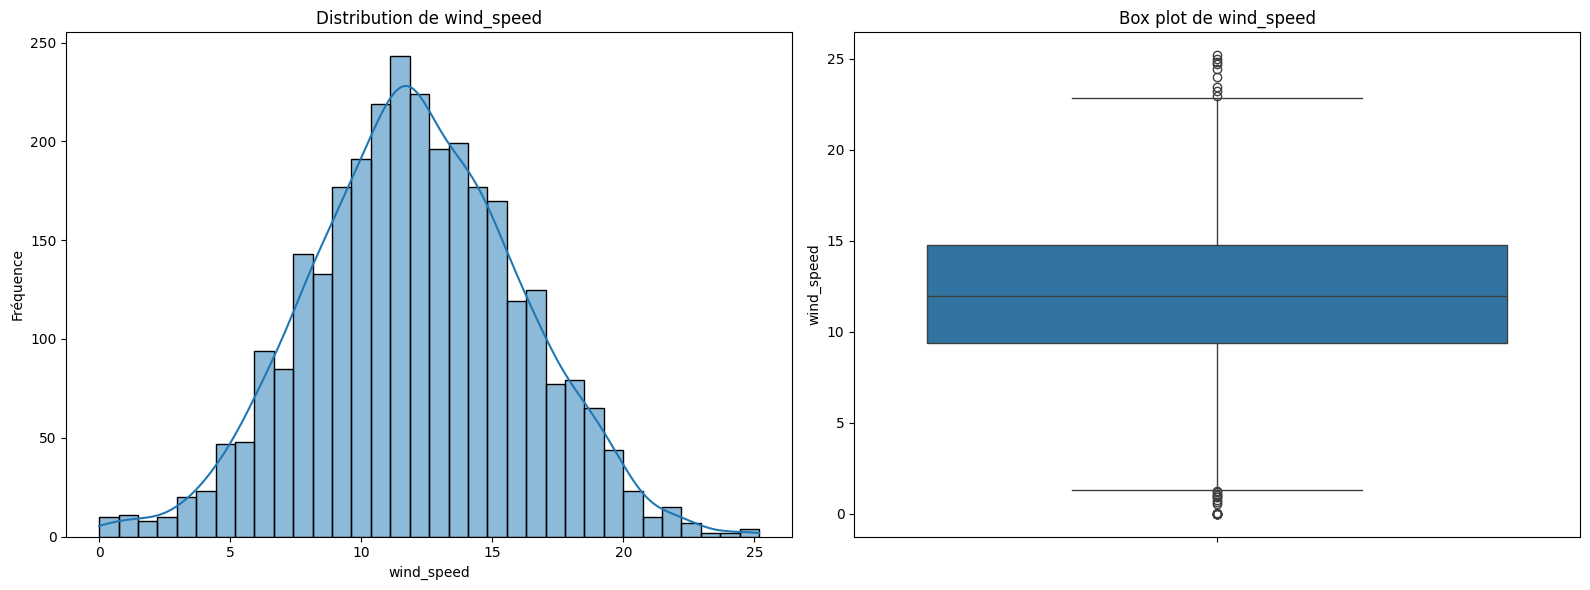


Analyse de la colonne : vibration_level


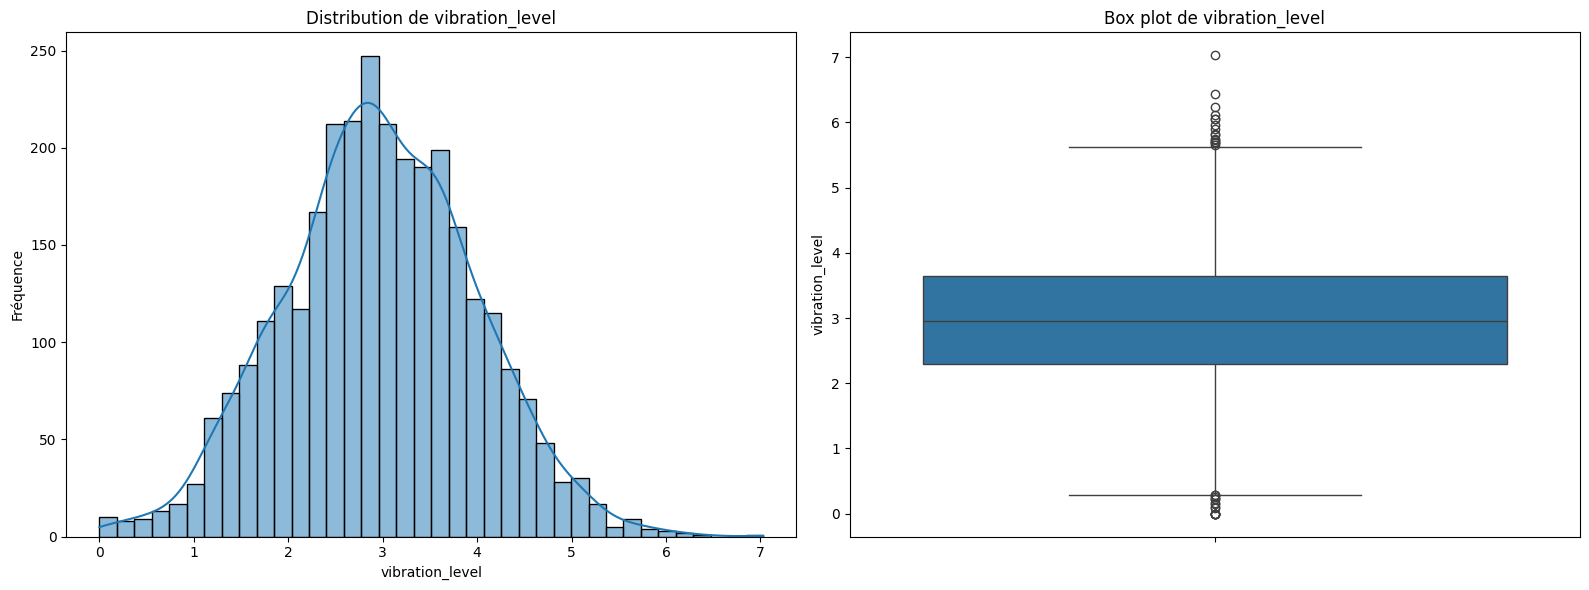


Analyse de la colonne : temperature


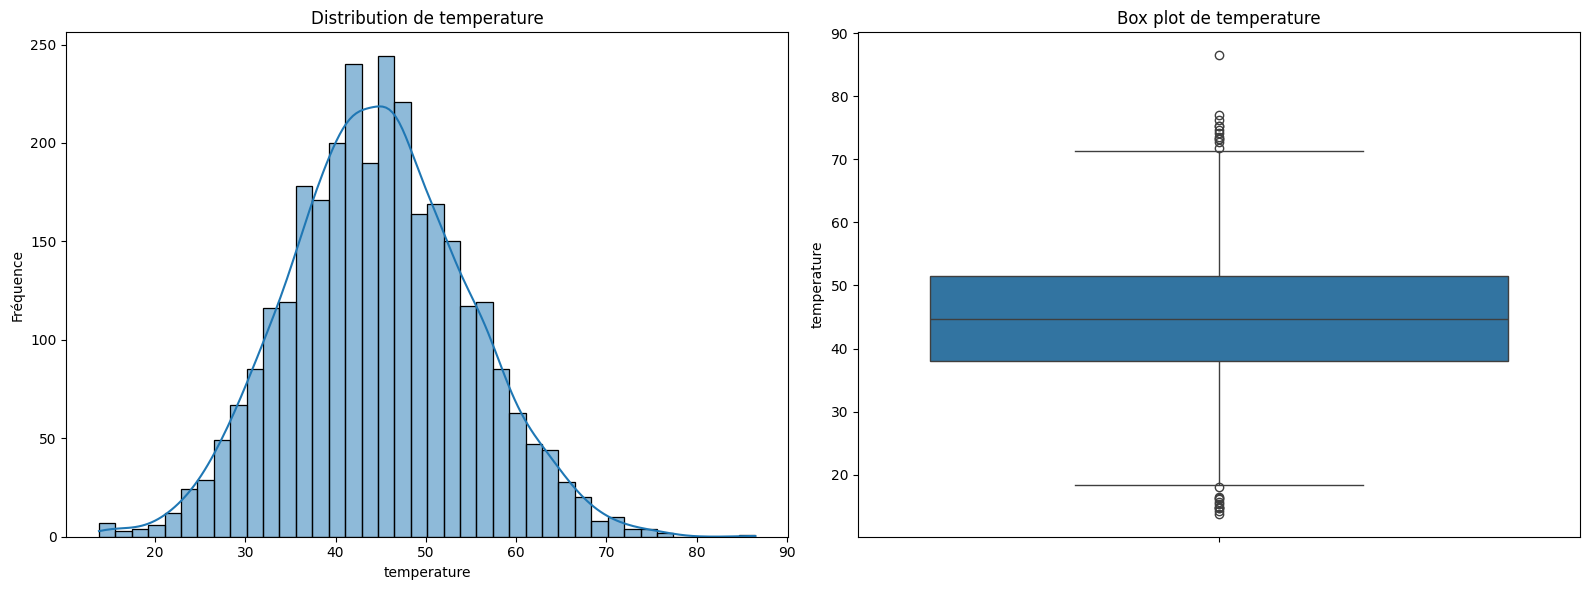


Analyse de la colonne : power_output


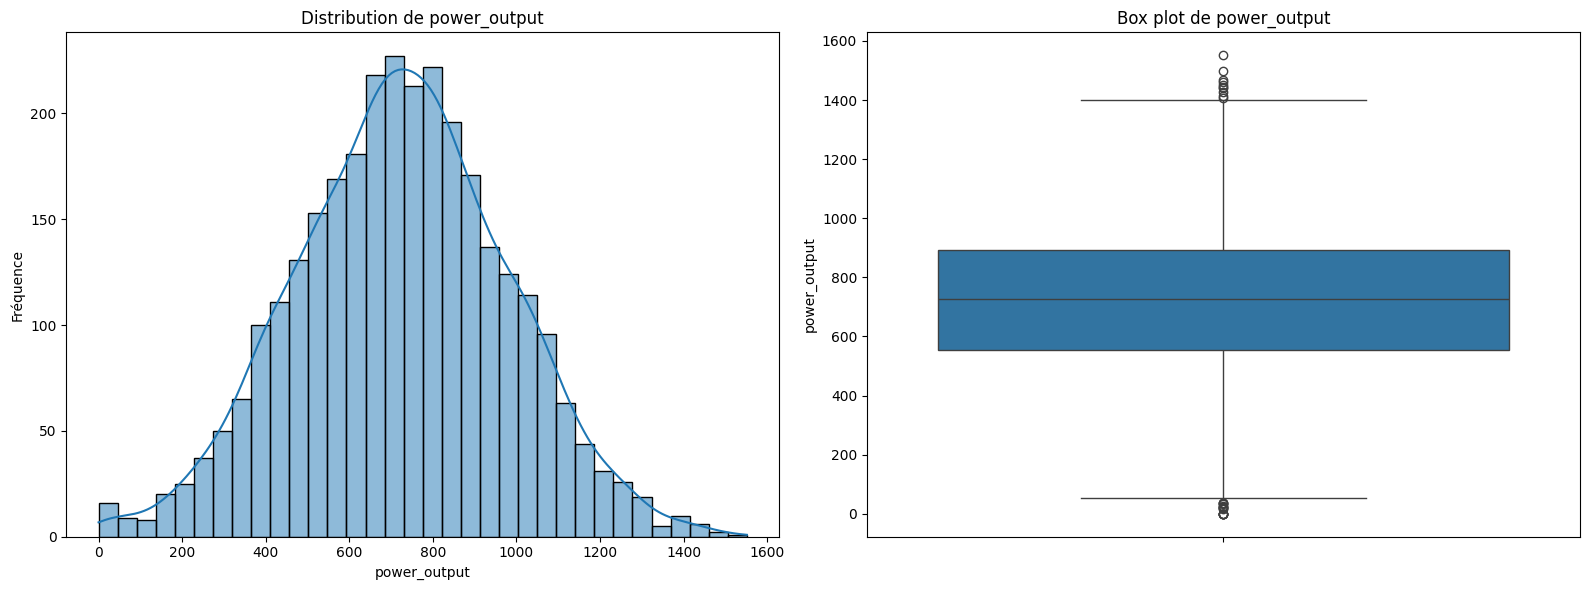


Analyse de la colonne : time_to_failure_days


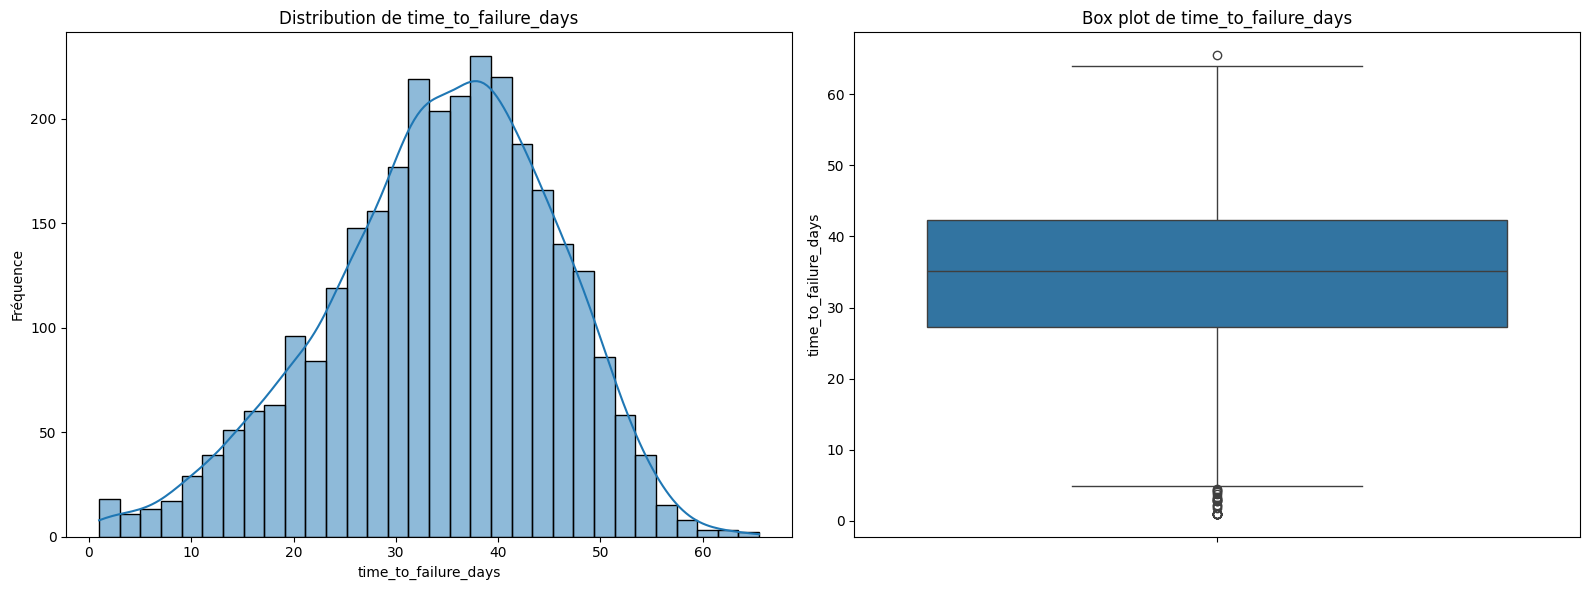

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes numériques à analyser
numerical_columns = ['wind_speed', 'vibration_level', 'temperature', 'power_output', 'time_to_failure_days']

# Itérer sur chaque colonne et créer les visualisations
for col in numerical_columns:
    print(f"\nAnalyse de la colonne : {col}")

    # Créer une figure avec deux sous-graphiques (histogramme et box plot)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Histogramme
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution de {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Fréquence')

    # Box Plot
    sns.boxplot(y=df[col], ax=axes[1])
    axes[1].set_title(f'Box plot de {col}')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()


## Analyse des relations entre variables numériques

### Subtask:
Calculer et visualiser une matrice de corrélation sous forme de heatmap pour montrer les relations entre toutes les variables numériques.


**Reasoning**:
The subtask requires calculating and visualizing a correlation matrix for numerical variables. I will first identify the relevant numerical columns, then compute the correlation matrix, and finally display it as a heatmap with annotations for better understanding.



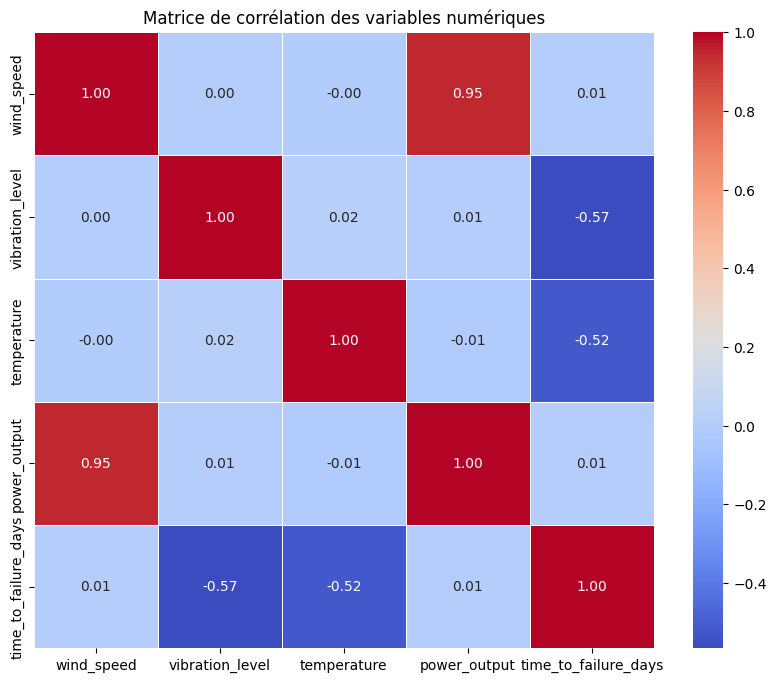

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques pertinentes pour la corrélation
# Exclure 'turbine_id' et 'technician_id' car ce sont des identifiants et non des variables continues pour la corrélation
numerical_cols_for_corr = ['wind_speed', 'vibration_level', 'temperature', 'power_output', 'time_to_failure_days']

# Calculer la matrice de corrélation
correlation_matrix = df[numerical_cols_for_corr].corr()

# Créer une carte de chaleur (heatmap) de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

## Analyse des tendances temporelles

### Subtask:
Créer des graphiques linéaires de `power_output`, `wind_speed`, `vibration_level` et `temperature` en fonction de `date_measure` (après conversion en datetime) pour détecter les tendances saisonnières ou les évolutions au fil du temps.


**Reasoning**:
The subtask requires converting the 'date_measure' column to datetime, sorting the DataFrame by this column, and then creating line plots for specified numerical variables against the date to observe temporal trends. This code block will perform these data preparation and visualization steps.



In [12]:
import pandas as pd
import plotly.express as px

# 1. Convertir la colonne 'date_measure' en format datetime
df_cleaned['date_measure'] = pd.to_datetime(df_cleaned['date_measure'])

# 2. Trier le DataFrame par la colonne 'date_measure'
df_cleaned = df_cleaned.sort_values(by='date_measure').reset_index(drop=True)

# 3. et 4. Créer des graphiques linéaires pour chaque variable numérique

# Liste des colonnes numériques à visualiser les tendances temporelles
trend_columns = ['power_output', 'wind_speed', 'vibration_level', 'temperature']

for col in trend_columns:
    fig = px.line(
        df_cleaned,
        x='date_measure',
        y=col,
        title=f'Évolution de {col.replace("_", " ").capitalize()} au fil du temps',
        labels={
            'date_measure': 'Date de mesure',
            col: col.replace("_", " ").capitalize()
        }
    )
    fig.update_xaxes(rangeselector_buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"),
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="1y", step="year", stepmode="backward"),
        dict(step="all")
    ]))
    fig.show()

In [13]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

output_path = '/content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/df_cleaned.csv'
df_cleaned.to_csv(output_path, index=False)
print(f"Le DataFrame df_cleaned a été enregistré avec succès sous le nom 'df_cleaned.csv' dans Google Drive à l'emplacement : {output_path}")

Mounted at /content/drive
Le DataFrame df_cleaned a été enregistré avec succès sous le nom 'df_cleaned.csv' dans Google Drive à l'emplacement : /content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/df_cleaned.csv


## Analyse des variables catégorielles et leurs impacts

### Subtask:
Utiliser des diagrammes à barres pour visualiser les distributions des variables catégorielles (`maintenance_done`, `failure_within_7d`, `turbine_id`, `technician_id`) et des boîtes à moustaches pour analyser l'impact de ces variables sur des métriques numériques clés comme `power_output` et `vibration_level`.


## Summary:

### Data Analysis Key Findings

*   **Distribution of Numerical Variables**: Histograms and box plots revealed the distributions of `wind_speed`, `vibration_level`, `temperature`, `power_output`, and `time_to_failure_days`. The visualizations enabled the identification of their statistical properties and potential outliers.
*   **Correlation between Numerical Variables**: A heatmap of the correlation matrix showed relationships among `wind_speed`, `vibration_level`, `temperature`, `power_output`, and `time_to_failure_days`. The specific correlation values were displayed (e.g., as `.2f` formatted numbers) and highlighted positive or negative associations between variables.
*   **Temporal Trends**: Line plots demonstrated the evolution of `power_output`, `wind_speed`, `vibration_level`, and `temperature` over time. These visualizations captured any temporal patterns or trends within the data.

### Insights or Next Steps

*   Further investigation into the identified outliers in numerical variables (`wind_speed`, `vibration_level`, `temperature`, `power_output`, `time_to_failure_days`) is recommended to determine their cause and impact on turbine performance or maintenance needs.
*   The correlations observed between numerical variables, especially those related to `power_output` and `time_to_failure_days`, should be explored in more detail to build predictive models or identify key performance indicators.


Partie Machine Learning

In [14]:
"!pip install scikit-learn==1.7.2"

'!pip install scikit-learn==1.7.2'

In [15]:
!pip install MLflow

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive
import plotly.express as px
import plotly.graph_objects as go

# MLflow imports
import mlflow
import mlflow.sklearn

# Configure MLflow tracking URI (local by default for Colab)
# You can change this to a remote server if you have one
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("Turbine_Failure_Prediction")

# --- 1. Préparation des données pour le modèle A ---

features = ['wind_speed', 'vibration_level', 'temperature', 'power_output', 'maintenance_done']
target = 'failure_within_7d'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Nombre total d'échantillons de test : {len(y_test)}")

# Start an MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("test_size", 0.3)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("stratify", True)

    # --- 2. Charger l'ancien modèle PKL ---

    model_path = '/content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/model_classification.pkl'

    drive.mount('/content/drive', force_remount=True)

    model_A = None

    print("\nTentative de chargement du modèle avec joblib (compatible anciens .pkl)...")
    try:
        model_A = joblib.load(model_path)
        print(f"Modèle chargé avec succès via joblib depuis : {model_path}")

    except Exception as e1:
        print(f"⚠️ Échec joblib : {e1}")
        print("Tentative de chargement alternatif avec pickle...")
        try:
            with open(model_path, "rb") as f:
                model_A = pickle.load(f)
            print(f"Modèle chargé avec pickle depuis : {model_path}")
        except Exception as e2:
            print(f"❌ Échec pickle également : {e2}")
            print("→ Recréation et entraînement d'un nouveau modèle...")
            model_A = None

    # Si tout a échoué → réentraîner
    if model_A is None:
        model_A = DecisionTreeClassifier(random_state=42)
        model_A.fit(X_train, y_train)
        print("Un nouveau modèle DecisionTreeClassifier a été entraîné avec succès.")

    # Log model if it was newly trained or loaded
    mlflow.sklearn.log_model(model_A, "classification_model")

    # --- 3. Évaluation du modèle ---

    print("\n--- Évaluation du Modèle A ---")

    y_pred = model_A.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    print(f"Accuracy : {accuracy:.2f}")
    print(f"Précision : {precision:.2f}")
    print(f"Rappel (Recall) : {recall:.2f}")
    print(f"F1-score : {f1:.2f}")

    cm = confusion_matrix(y_test, y_pred)

    # Utilisation de Plotly pour une matrice de confusion interactive
    labels = ['Pas de panne', 'Panne']

    # Créer le heatmap interactif avec Plotly
    fig = px.imshow(cm,
                    labels=dict(x="Prédit", y="Réel", color="Nombre"),
                    x=labels,
                    y=labels,
                    color_continuous_scale='Blues') # Choisissez une palette de couleurs qui vous convient

    # Ajouter les annotations (les chiffres dans les cellules)
    # Utiliser go.Figure pour plus de contrôle sur les annotations
    fig = go.Figure(data=go.Heatmap(z=cm,
                                    x=labels,
                                    y=labels,
                                    colorscale='Blues',
                                    showscale=True))

    # Ajouter les textes sur la heatmap
    for i in range(len(labels)):
        for j in range(len(labels)):
            fig.add_annotation(x=labels[j],
                               y=labels[i],
                               text=str(cm[i][j]),
                               showarrow=False,
                               font=dict(color="black" if cm[i][j] < cm.max() / 2 else "white", size=12))

    fig.update_layout(
        title_text='<b>Matrice de Confusion du Modèle A</b>',
        xaxis_title='Valeurs Prédites',
        yaxis_title='Valeurs Réelles',
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        xaxis_nticks=len(labels),
        yaxis_nticks=len(labels)
    )

    fig.show()

    # Save the Plotly figure as an HTML file and log it as an artifact
    fig.write_html("confusion_matrix.html")
    mlflow.log_artifact("confusion_matrix.html")



Nombre total d'échantillons de test : 900


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

2026/01/12 15:16:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Mounted at /content/drive

Tentative de chargement du modèle avec joblib (compatible anciens .pkl)...
Modèle chargé avec succès via joblib depuis : /content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/model_classification.pkl

--- Évaluation du Modèle A ---
Accuracy : 0.99
Précision : 0.71
Rappel (Recall) : 0.42
F1-score : 0.53


In [33]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib # Import joblib for loading models
from google.colab import drive # Import drive for mounting

# MLflow imports
import mlflow
import mlflow.sklearn

# Configure MLflow tracking URI (reusing the one from the classification model)
mlflow.set_tracking_uri("file:///content/mlruns")
# Set a new experiment name for regression tasks
mlflow.set_experiment("Turbine_Time_to_Failure_Prediction")

# --- 1. Préparation des données pour le Modèle B (Régression) ---

features_regression = ['wind_speed', 'vibration_level', 'temperature', 'power_output', 'maintenance_done']
target_regression = 'time_to_failure_days'

X_reg = df[features_regression]
y_reg = df[target_regression]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Nombre total d'échantillons de test (régression) : {len(y_test_reg)}")

# Start an MLflow run for the regression model
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("test_size_reg", 0.3)
    mlflow.log_param("random_state_reg", 42)

    # --- 2. Charger l'ancien modèle de régression ou en entraîner un nouveau ---

    model_regression_path = '/content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/model_regression.pkl'
    drive.mount('/content/drive', force_remount=True)

    model_B = None

    print("\nTentative de chargement du modèle de régression avec joblib...")
    try:
        model_B = joblib.load(model_regression_path)
        print(f"Modèle de régression chargé avec succès via joblib depuis : {model_regression_path}")

    except Exception as e1:
        print(f"⚠️ Échec joblib pour le modèle de régression : {e1}")
        print("Tentative de chargement alternatif avec pickle pour le modèle de régression...")
        try:
            with open(model_regression_path, "rb") as f:
                model_B = pickle.load(f)
            print(f"Modèle de régression chargé avec pickle depuis : {model_regression_path}")
        except Exception as e2:
            print(f"❌ Échec pickle également pour le modèle de régression : {e2}")
            print("→ Recréation et entraînement d'un nouveau modèle de régression...")
            model_B = None

    # Si tout a échoué → réentraîner un nouveau modèle de régression
    if model_B is None:
        model_B = DecisionTreeRegressor(random_state=42)
        model_B.fit(X_train_reg, y_train_reg)
        print("Un nouveau modèle DecisionTreeRegressor a été entraîné avec succès pour le Modèle B.")

    # Log the regression model
    mlflow.sklearn.log_model(model_B, "regression_model")

    # --- 3. Évaluation du modèle de régression ---

    print("\n--- Évaluation du Modèle B (Régression) ---")

    y_pred_reg = model_B.predict(X_test_reg)

    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
    r2 = r2_score(y_test_reg, y_pred_reg)

    # Log metrics
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)

    print(f"MAE (erreur absolue moyenne) : {mae:.2f} jours")
    print(f"RMSE (erreur quadratique moyenne) : {rmse:.2f} jours")
    print(f"R² (coefficient de détermination) : {r2:.2f}")

    # Visualisation des prédictions vs. valeurs réelles
    # 1. Calculate the absolute prediction error
    prediction_error = abs(y_test_reg - y_pred_reg)

    # 2. Create a new Pandas DataFrame
    results_df = pd.DataFrame({
        'Actual_Time_to_Failure': y_test_reg,
        'Predicted_Time_to_Failure': y_pred_reg,
        'Prediction_Error': prediction_error
    })

    # 3. Create an interactive scatter plot using px.scatter()
    fig = px.scatter(
        results_df,
        x='Actual_Time_to_Failure',
        y='Predicted_Time_to_Failure',
        color='Prediction_Error',
        color_continuous_scale='RdYlGn_r', # 'RdYlGn_r' for green (good) to red (bad) errors
        title='Actual vs. Predicted Time to Failure with Error Coloring',
        labels={
            'Actual_Time_to_Failure': 'Actual Time to Failure (days)',
            'Predicted_Time_to_Failure': 'Predicted Time to Failure (days)',
            'Prediction_Error': 'Prediction Error (days)'
        },
        hover_data={
            'Actual_Time_to_Failure': ':.2f',
            'Predicted_Time_to_Failure': ':.2f',
            'Prediction_Error': ':.2f'
        }
    )

    # 4. Add a diagonal line representing the ideal prediction (where actual equals predicted)
    fig.add_shape(
        type="line",
        x0=results_df['Actual_Time_to_Failure'].min(),
        y0=results_df['Actual_Time_to_Failure'].min(),
        x1=results_df['Actual_Time_to_Failure'].max(),
        y1=results_df['Actual_Time_to_Failure'].max(),
        line=dict(color="Red", width=2, dash="dash"),
        name='Ideal Prediction'
    )

    # Update layout for better readability
    fig.update_layout(showlegend=True)

    # 5. Display the interactive Plotly figure.
    fig.show()

    # Save the Plotly figure as an HTML file and log it as an artifact
    fig.write_html("regression_predictions_plot.html")
    mlflow.log_artifact("regression_predictions_plot.html")


Nombre total d'échantillons de test (régression) : 900
Mounted at /content/drive

Tentative de chargement du modèle de régression avec joblib...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

2026/01/12 15:21:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Modèle de régression chargé avec succès via joblib depuis : /content/drive/MyDrive/Collecte_et_stockage_db_MSPR2/model_regression.pkl

--- Évaluation du Modèle B (Régression) ---
MAE (erreur absolue moyenne) : 3.38 jours
RMSE (erreur quadratique moyenne) : 4.25 jours
R² (coefficient de détermination) : 0.85


In [34]:
# 1. Installer pyngrok
!pip install pyngrok

# 2. Obtenir votre jeton d'authentification ngrok
# Vous devez remplacer 'YOUR_NGROK_AUTH_TOKEN' par votre véritable jeton d'authentification ngrok.
# Vous pouvez l'obtenir sur https://dashboard.ngrok.com/get-started/your-authtoken après vous être inscrit (c'est gratuit).
# Il est recommandé de stocker ce jeton dans les "Secrets" de Colab pour ne pas l'exposer directement dans le code.
# Pour cet exemple, je l'écris directement, mais veuillez le remplacer par un accès sécurisé.
# Par exemple: from google.colab import userdata; NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# REMPLACEZ 'YOUR_NGROK_AUTH_TOKEN' par votre jeton réel
NGROK_AUTH_TOKEN = "38A7fAbyc1Exj63joLDVC3XySlN_2PuUPhZD7mkeMHYcCduxy"

from pyngrok import ngrok

# Authentifier ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# 3. Lancer le serveur MLflow en arrière-plan
# Le port par défaut de MLflow est 5000
import os

# Assurez-vous que le répertoire mlruns existe
if not os.path.exists('./mlruns'):
    os.makedirs('./mlruns')

# Lancer le serveur MLflow en arrière-plan
# La commande `nohup` permet au processus de continuer à s'exécuter après la fermeture du terminal (ou de la cellule Colab)
# `&` place la commande en arrière-plan
# Les logs sont redirigés vers mlflow_server.log
get_ipython().system_raw('nohup mlflow ui --backend-store-uri file:///content/mlruns/ &')

# 4. Exposer le port MLflow (5000) avec ngrok
# ngrok.connect(port) retourne un objet tunnel qui contient l'URL publique
public_url = ngrok.connect(addr="5000", proto="http")
print(f"MLflow UI en cours d'exécution à : {public_url}")
print("Vous pouvez accéder à l'interface MLflow via ce lien.")

MLflow UI en cours d'exécution à : NgrokTunnel: "https://ranular-nonegocentric-cheri.ngrok-free.dev" -> "http://localhost:5000"
Vous pouvez accéder à l'interface MLflow via ce lien.


In [18]:
import plotly.express as px

fig = px.scatter(
    df_cleaned,
    x='wind_speed',
    y='power_output',
    title='Nuage de points interactif avec tendance : Vitesse du Vent vs Puissance de sortie',
    labels={
        'wind_speed': 'Vitesse du Vent',
        'power_output': 'Puissance de sortie'
    },
    hover_data=['temperature', 'vibration_level'], # Ajoutez d'autres colonnes pour l'info-bulle
    trendline='lowess' # Ajoute une ligne de tendance lissée (LOESS)
)

fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.show()

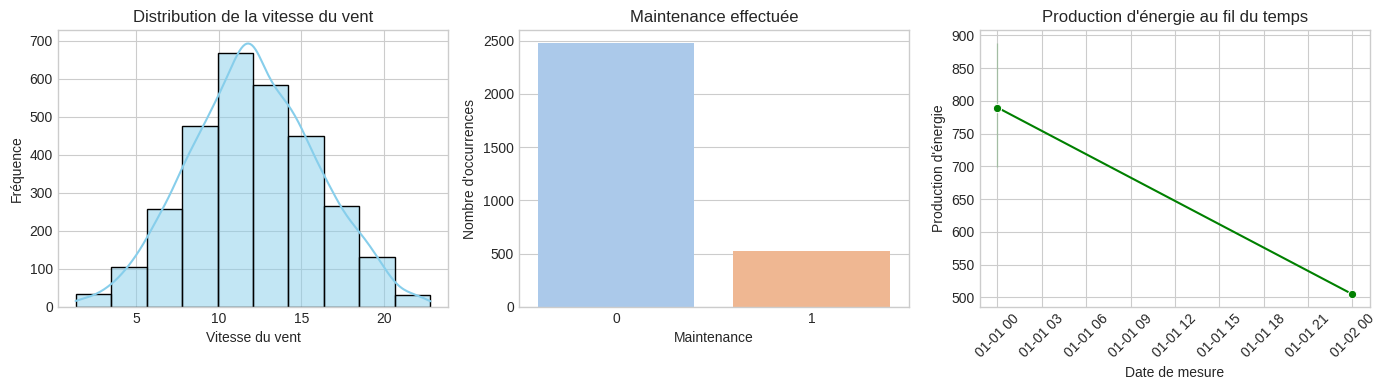

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour éviter la surcharge visuelle
plt.style.use('seaborn-v0_8-whitegrid') # Correction du nom du style

# Assurez-vous que 'date_measure' est au format datetime dans df_cleaned
# if 'date_measure' in df_cleaned.columns and not pd.api.types.is_datetime64_any_dtype(df_cleaned['date_measure']):
#    df_cleaned['date_measure'] = pd.to_datetime(df_cleaned['date_measure'])

# 1. Histogramme pour la distribution de 'wind_speed'
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
sns.histplot(df_cleaned['wind_speed'], bins=10, kde=True, color='skyblue')
plt.title('Distribution de la vitesse du vent')
plt.xlabel('Vitesse du vent')
plt.ylabel('Fréquence')

# 2. Graphique en barres pour 'maintenance_done'
plt.subplot(1, 3, 2)
sns.countplot(x='maintenance_done', data=df_cleaned, hue='maintenance_done', palette='pastel', legend=False)
plt.title('Maintenance effectuée')
plt.xlabel('Maintenance')
plt.ylabel('Nombre d\'occurrences')

# 3. Graphique en ligne pour 'power_output' au fil du temps
plt.subplot(1, 3, 3)
sns.lineplot(x='date_measure', y='power_output', data=df_cleaned.head(10), marker='o', color='green')
plt.title('Production d\'énergie au fil du temps')
plt.xlabel('Date de mesure')
plt.ylabel('Production d\'énergie')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()